In [1]:
!pip install -q kaggle

In [5]:
import google.colab.files as files
files.upload()

MessageError: ignored

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-07-24 09:20:05           9911  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6085  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2262  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2507  
fatiimaezzahra/

In [ ]:
!kaggle datasets download -d arnaud58/selfie2anime

 96% 373M/390M [00:03<00:00, 119MB/s]
100% 390M/390M [00:03<00:00, 111MB/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, Reshape, Conv2D, Conv2DTranspose, ReLU, LeakyReLU,InputLayer, UpSampling2D,ZeroPadding2D
import tensorflow.keras.datasets as dts 
from PIL import Image, ImageOps

In [ ]:
from tensorflow.compat.v1 import keras
import tensorflow as tf

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
import zipfile
with zipfile.ZipFile('/content/selfie2anime.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/faceTOanime_2')

In [ ]:
from skimage.io import imread
import glob

imgs = []
for filename in glob.glob('/content/faceTOanime_2/trainA/*.jpg'):
  imgs.append(imread(filename))

In [ ]:
len(imgs)

3400

In [ ]:
for i in range(len(imgs)):
  imgs[i] = np.array(Image.fromarray(imgs[i]).resize((128,128)))

imgs = np.array(imgs)

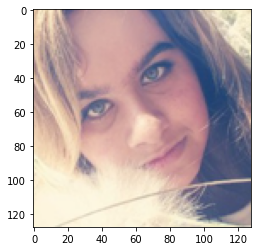

In [ ]:
plt.imshow(imgs[0])

In [ ]:
x_train = imgs
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

In [ ]:
x_train.shape

(3400, 128, 128, 3)

In [ ]:
lr = 0.00005
batch_size = 64
betas = (0.5, 0.999)
noise_size = 256

In [ ]:
discriminator = keras.Sequential([
  InputLayer((128,128,3)),
  Conv2D(32, kernel_size=3, strides=2, padding="same"),
  LeakyReLU(alpha=0.2),
  Dropout(0.25),
  Conv2D(64, kernel_size=3, strides=2, padding="same"),
  ZeroPadding2D(padding=((0,1),(0,1))),
  BatchNormalization(momentum=0.8,),
  LeakyReLU(alpha=0.2),
  Dropout(0.25),
  Conv2D(128, kernel_size=3, strides=2, padding="same"),
  BatchNormalization(momentum=0.8),
  LeakyReLU(alpha=0.2),
  Dropout(0.25),
  Conv2D(256, kernel_size=3, strides=1, padding="same"),
  BatchNormalization(momentum=0.8),
  LeakyReLU(alpha=0.2),
  Dropout(0.25),
  Flatten(),
  Dense(1, activation='sigmoid'),
])

discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 33, 33, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33, 33, 64)        0

In [ ]:
optimizer = keras.optimizers.Adam(lr,betas[0],betas[1])
discriminator.compile(loss='binary_crossentropy', 
  optimizer=optimizer)

In [ ]:
generator = keras.Sequential([
  InputLayer((noise_size,)),
  Dense(128 * 8 * 8, activation="relu"),
  Reshape((8, 8, 128)),
  UpSampling2D(),
  Conv2D(128, kernel_size=3, padding="same"),
  BatchNormalization(momentum=0.8),
  ReLU(),
  UpSampling2D(),
  Conv2D(128, kernel_size=3, padding="same"),
  BatchNormalization(momentum=0.8),
  ReLU(),
  UpSampling2D(),
  Conv2D(128, kernel_size=3, padding="same"),
  BatchNormalization(momentum=0.8),
  ReLU(),
  UpSampling2D(),
  Conv2D(128, kernel_size=3, padding="same"),
  BatchNormalization(momentum=0.8),
  ReLU(),
  Conv2D(128, kernel_size=3, padding="same"),
  BatchNormalization(momentum=0.8),
  ReLU(),
  Conv2D(3, kernel_size=3, padding="same", activation='tanh')
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)      

In [ ]:
optimizer = keras.optimizers.Adam(lr,betas[0],betas[1])
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
optimizer = keras.optimizers.Adam(lr,betas[0],betas[1])
z = Input(shape=(noise_size,))
img = generator(z)
valid = discriminator(img)
combined = keras.Model(z, valid)

In [ ]:
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
!mkdir gan
!mkdir gan/images


def save_imgs(epoch):
  r, c = 5, 5

  noise = np.random.normal(0, 1, (25, noise_size))
  generated_samples = generator(noise)
  generated_samples = np.array(generated_samples)
  generated_samples = ((generated_samples * 0.5) + 0.5) * 255
  generated_samples = generated_samples.round()
  generated_samples = generated_samples.astype(np.uint8)

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(generated_samples[cnt])
      #axs[i,j].axis('off')
      cnt += 1
  fig.savefig("gan/images/mnist_%d.png" % epoch)
  plt.close()

In [ ]:
#discriminator = keras.models.load_model('/content/drive/MyDrive/ColabFiles/discriminator_4000.h5')
#generator = keras.models.load_model('/content/drive/MyDrive/ColabFiles/generator_4000.h5')

In [ ]:
num_epochs = 7000
save_step = 100

In [ ]:
for epoch in range(0,num_epochs):  
  idx = np.random.randint(0,x_train.shape[0], batch_size)
  imgs = x_train[idx]
  noise = np.random.normal(0, 1, (batch_size, noise_size))
  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))
  d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  noise = np.random.normal(0, 1, (batch_size, noise_size))
  valid_y = np.array([1] * batch_size)

  discriminator.trainable = False
  g_loss = combined.train_on_batch(noise, valid_y)
  discriminator.trainable = True

  if (epoch % 100) == 0:
    save_imgs(epoch)
  
  print (epoch, d_loss, g_loss)

6001 0.9719745218753815 0.4203617572784424
6002 0.99695785343647 0.4287681579589844
6003 0.9819591790437698 0.4596666395664215
6004 0.8828003257513046 0.48817920684814453
6005 1.0697583556175232 0.3928822875022888
6006 1.0925918966531754 0.42653435468673706
6007 1.0612710416316986 0.47740113735198975
6008 0.9444641172885895 0.45587849617004395
6009 1.0082240998744965 0.388614296913147
6010 0.9887771531939507 0.37919217348098755
6011 0.9790093004703522 0.4479585587978363
6012 0.9093853980302811 0.6026480793952942
6013 0.94247717410326 0.45411092042922974
6014 1.0275636985898018 0.4292318522930145
6015 1.1281319558620453 0.45228540897369385
6016 0.9493259862065315 0.4751649498939514
6017 1.1053243577480316 0.42627403140068054
6018 1.1225888431072235 0.5365675091743469
6019 1.0159363448619843 0.48616570234298706
6020 1.0976814329624176 0.4258875846862793
6021 1.0285256206989288 0.4607960283756256
6022 1.0628333315253258 0.42767906188964844
6023 1.0831346213817596 0.4282940626144409
6024 0

In [ ]:
noise = np.random.normal(0, 1, (16, noise_size))
generated_samples = generator(noise)
generated_samples = np.array(generated_samples)
generated_samples = ((generated_samples * 0.5) + 0.5) * 255
generated_samples = generated_samples.round()
generated_samples = generated_samples.astype(np.uint8)

In [ ]:
generated_samples.shape

(16, 128, 128, 3)

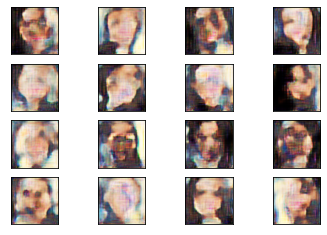

In [ ]:
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i])
    plt.xticks([])
    plt.yticks([])

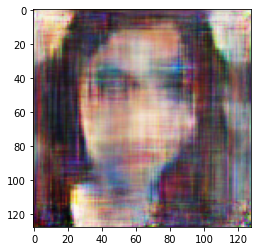

In [ ]:
plt.imshow(generated_samples[9])

In [ ]:
'''discriminator.save('discriminator_6000.h5')
generator.save('generator_6000.h5')

import shutil
shutil.make_archive('history', 'zip', '/content/gan/images')'''

'/content/history.zip'